The purpose of this notebook is to look at how the different xylem damage models impact the optimal stomatal size and resulting CO2 flux of a tree over time.

In [2]:
from profit_optimisation_model.src.vapour_pressure_deficit_calculation import vapour_pressure_deficit
from profit_optimisation_model.src.leaf_air_coupling_model import LeafAirCouplingModel
from profit_optimisation_model.src.rubisco_CO2_and_O_model import RubiscoRates
from profit_optimisation_model.src.electron_transport_rate_model import ElectronTransportRateModel

# -- Conductance models --
from profit_optimisation_model.src.HydraulicConductanceModels.cumulative_Weibull_distribution_model import cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials
from profit_optimisation_model.src.HydraulicConductanceModels.DynamicModels.capped_conductance_model import CappedHydraulicConductanceModel
from profit_optimisation_model.src.HydraulicConductanceModels.DynamicModels.D_S_Mackay_damage_model import D_S_Mackay_damage_model_from_conductance_loss
from profit_optimisation_model.src.HydraulicConductanceModels.DynamicModels.Analytic_D_S_Mackay_damage_model import analytic_D_S_Mackay_damage_model_from_conductance_loss
from profit_optimisation_model.src.HydraulicConductanceModels.DynamicModels.Analytic_recoverable_D_S_Mackay_damage_model import analytic_recoverable_D_S_Mackay_damage_model_from_conductance_loss
from profit_optimisation_model.src.HydraulicConductanceModels.DynamicModels.JB_xylem_impairment_model import JB_xylem_damage_model_from_conductance_loss

# -- Temperature dependency models --
from profit_optimisation_model.src.TemperatureDependenceModels.arrhenius_and_peaked_arrhenius_function import PeakedArrheniusModel, ArrheniusModel
from profit_optimisation_model.src.TemperatureDependenceModels.Q10_temperature_dependence_model import Q10TemperatureDependenceModel
from profit_optimisation_model.src.TemperatureDependenceModels.temperature_dependence_model import LowTemperatureAdjustedModel

# -- Photosynthesis models --
from profit_optimisation_model.src.PhotosynthesisModels.photosynthesis_model import PhotosynthesisModel
from profit_optimisation_model.src.PhotosynthesisModels.Bonan_Model import PhotosynthesisModelRubiscoLimitedBonan as PhotosynthesisModelRubiscoLimited
from profit_optimisation_model.src.PhotosynthesisModels.Bonan_Model import PhotosynthesisModelElectronTransportLimitedBonan as PhotosynthesisModelElectronTransportLimited

# -- Profit Models --
from profit_optimisation_model.src.ProfitModels.CO2GainModels.CO2_gain_profit_max_model import ProfitMaxCO2GainModel as CO2GainModel
from profit_optimisation_model.src.ProfitModels.HydraulicCostModels.hydraulic_cost_profit_max_model import ProfitMaxHydraulicCostModel as HydraulicCostModel
from profit_optimisation_model.src.ProfitModels.profit_max_model import ProfitMaxModel

from profit_optimisation_model.src.conversions import (magnitude_conversion,
                                                       mole_carbon_to_grams,
                                                       per_day_to_per_second,
                                                       per_second_to_per_half_hour,
                                                       convert_transpiration_rate_to_latent_energy,
                                                       short_wave_to_photosynthetically_active_radiation,
                                                       light_energy_in_joules_to_micro_moles_of_light,
                                                       degrees_kelvin_to_centigrade,
                                                       degrees_centigrade_to_kelvin,
                                                       convert_stomatal_conductance_of_carbon_to_water)

from xarray import open_dataset
from pandas import DataFrame, date_range
from numpy import nan, zeros, linspace

from matplotlib import pyplot as plt

# Model setup

Before we are able to investigate. anything it is necessary to setup a control and multiple test models. For comparative purposes we will use a cumulative Weibull distribution as the base conductance model, with the xylem damage models being both a capped conductance model, and the model described in [D.S.Mackay et. al. 2015](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2015WR017244).

## Conductance Model
The code segment bellow sets up the three different conductance models with xylem damage.

In [3]:
# Conductance model
P50 = -3 # MPa
P88 = -4 # MPa
k_max = 0.2 # mmol m-2 s-1 MPa-1

critical_conductance_loss_fraction = 0.9
xylem_recovery_water_potnetial = 0.
PLC_damage_threshold = 0.12

recovery_rate = 0.
recovery_shape = 1.
damage_rate = 0.5
damage_shape = 1.

sapwood_area = 1.0
growth_rate = 0.1
death_rate = 0.1
death_shape = 1.

default_CW_conductance_model = cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials(k_max,
                                                                                                               P50,
                                                                                                               P88,
                                                                                                               0.50,
                                                                                                               0.88,
                                                                                                               critical_conductance_loss_fraction,
                                                                                                               xylem_recovery_water_potnetial,
                                                                                                               PLC_damage_threshold
                                                                                                              )

capped_CW_conductance_model = CappedHydraulicConductanceModel(default_CW_conductance_model,
                                                              1.1*k_max
                                                             )

D_S_Mackay_CW_conductance_model = D_S_Mackay_damage_model_from_conductance_loss(k_max,
                                                                                P50,
                                                                                P88,
                                                                                0.50,
                                                                                0.88,
                                                                                1000,
                                                                                critical_conductance_loss_fraction,
                                                                                xylem_recovery_water_potnetial,
                                                                                PLC_damage_threshold
                                                                               )

analytic_D_S_Mackay_CW_conductance_model = analytic_D_S_Mackay_damage_model_from_conductance_loss(k_max,
                                                                                                  P50,
                                                                                                  P88,
                                                                                                  0.50,
                                                                                                  0.88,
                                                                                                  critical_conductance_loss_fraction,
                                                                                                  xylem_recovery_water_potnetial,
                                                                                                  PLC_damage_threshold
                                                                                                 )

analytic_recoverable_D_S_Mackay_CW_conductance_model = analytic_recoverable_D_S_Mackay_damage_model_from_conductance_loss(k_max,
                                                                                                  P50,
                                                                                                  P88,
                                                                                                  0.50,
                                                                                                  0.88,
                                                                                                  critical_conductance_loss_fraction,
                                                                                                  recovery_rate,
                                                                                                  damage_rate)

JB_xylem_damage_model = JB_xylem_damage_model_from_conductance_loss(k_max,
                                                                    sapwood_area,
                                                                    P50,
                                                                    P88,
                                                                    0.50,
                                                                    0.88,
                                                                    critical_conductance_loss_fraction,
                                                                    recovery_rate,
                                                                    recovery_shape,
                                                                    damage_rate,
                                                                    damage_shape,
                                                                    growth_rate,
                                                                    death_rate,
                                                                    death_shape)

## Hydraulic cost models

In [4]:
critical_leaf_water_potential = default_CW_conductance_model.water_potential_from_conductivity_loss_fraction(0.95)

default_CW_hydraulic_cost_model = HydraulicCostModel(default_CW_conductance_model,
                                                     critical_leaf_water_potential
                                                    )

capped_CW_hydraulic_cost_model = HydraulicCostModel(capped_CW_conductance_model,
                                                    critical_leaf_water_potential
                                                   )

D_S_Mackay_CW_hydraulic_cost_model = HydraulicCostModel(D_S_Mackay_CW_conductance_model,
                                                        critical_leaf_water_potential
                                                       )

analytic_D_S_Mackay_CW_hydraulic_cost_model = HydraulicCostModel(analytic_D_S_Mackay_CW_conductance_model,
                                                                 critical_leaf_water_potential
                                                                )

analytic_recoverable_D_S_Mackay_CW_hydraulic_cost_model = HydraulicCostModel(analytic_recoverable_D_S_Mackay_CW_conductance_model,
                                                                             critical_leaf_water_potential
                                                                            )

JB_hydraulic_cost_model = HydraulicCostModel(JB_xylem_damage_model,
                                             critical_leaf_water_potential
                                            )

## Leaf atmosphere coupling

In [5]:
leaf_air_coupling_model = LeafAirCouplingModel()

## Photosynthesis model

In [6]:
# -- Rubisco limited model --
photosynthesis_rubisco_limited_model = PhotosynthesisModelRubiscoLimited()

# -- Electron transport rate limmited model --
photosynthesis_electron_transport_limited_model = PhotosynthesisModelElectronTransportLimited()

photosynthesis_model = PhotosynthesisModel(photosynthesis_rubisco_limited_model,
                                           photosynthesis_electron_transport_limited_model
                                          )

## CO2 gain

In [7]:
CO2_gain_model = CO2GainModel(leaf_air_coupling_model,
                              photosynthesis_model)

## Profet optimisation models

Now we create a profit optimisation model for each of the different conductance models.

In [8]:
default_CW_profit_optimisation_model = ProfitMaxModel(default_CW_hydraulic_cost_model,
                                                      leaf_air_coupling_model,
                                                      CO2_gain_model
                                                     )

capped_CW_profit_optimisation_model = ProfitMaxModel(capped_CW_hydraulic_cost_model,
                                                     leaf_air_coupling_model,
                                                     CO2_gain_model
                                                    )

D_S_Mackay_CW_profit_optimisation_model = ProfitMaxModel(D_S_Mackay_CW_hydraulic_cost_model,
                                                         leaf_air_coupling_model,
                                                         CO2_gain_model
                                                        )

analytic_D_S_Mackay_CW_profit_optimisation_model = ProfitMaxModel(analytic_D_S_Mackay_CW_hydraulic_cost_model,
                                                                  leaf_air_coupling_model,
                                                                  CO2_gain_model
                                                                 )

analytic_recoverable_D_S_Mackay_CW_profit_optimisation_model = ProfitMaxModel(analytic_recoverable_D_S_Mackay_CW_hydraulic_cost_model,
                                                                              leaf_air_coupling_model,
                                                                              CO2_gain_model
                                                                             )

JB_CW_profit_optimisation_model = ProfitMaxModel(JB_hydraulic_cost_model,
                                                 leaf_air_coupling_model,
                                                 CO2_gain_model
                                                )

profit_optimisation_models = [default_CW_profit_optimisation_model,
                              capped_CW_profit_optimisation_model,
                              D_S_Mackay_CW_profit_optimisation_model,
                              analytic_D_S_Mackay_CW_profit_optimisation_model,
                              analytic_recoverable_D_S_Mackay_CW_profit_optimisation_model,
                              JB_CW_profit_optimisation_model
                             ]

profit_optimisation_model_labels = ["default", 
                                    "capped", 
                                    "D.S.Mackay", 
                                    "analytic D.S.Mackay", 
                                    "analytic recoverable D.S.Mackay",
                                    "JB growth and death model"
                                   ]

# Constant environmental conditions

The first thing to test is how the different models behave under the set of constant environmental conditions listed in the code block below.

In [9]:
# Soil properties
soil_water_potential = -1.0 # MPa

# Temperature
air_temperature = degrees_centigrade_to_kelvin(25.)

# Transpiration drivers
air_vapour_pressure_deficit = 1 # kPa
air_pressure = 101.9 # kPa

# Photosynthesis drivers
atmospheric_CO2_concentration = 419. # (umol mol-1)
photosynthetically_active_radiation = 1000. #(umol m-2 s-1)
intercellular_oxygen = 210.0 #(umol mol-1)

Lets apply this over a series of time steps recording the outputs of each model.

In [10]:
time_steps = 200
time_step_size = 1. # h

number_of_models = len(profit_optimisation_models)

time = [i*time_step_size for i in range(time_steps)]

# Number of sample points used when finding optimal leaf water potential
number_of_sample_points = 1000

# -- setup output arrays --
optimal_leaf_water_potential = zeros([number_of_models, time_steps])
net_CO2_uptake               = zeros([number_of_models, time_steps])
transpiration_rate           = zeros([number_of_models, time_steps])
intercellular_CO2            = zeros([number_of_models, time_steps])
stomatal_conductance_to_CO2  = zeros([number_of_models, time_steps])
k_max                        = zeros([number_of_models, time_steps])

for i in range(number_of_models):
    for j in range(time_steps):
        [optimal_leaf_water_potential[i,j],
         net_CO2_uptake[i,j],
         transpiration_rate[i,j],
         intercellular_CO2[i,j],
         stomatal_conductance_to_CO2[i,j]] = profit_optimisation_models[i].calculate_time_step(time_step_size,
                                                                                               soil_water_potential,
                                                                                               air_temperature,
                                                                                               air_vapour_pressure_deficit,
                                                                                               air_pressure,
                                                                                               atmospheric_CO2_concentration,
                                                                                               intercellular_oxygen,
                                                                                               photosynthetically_active_radiation,
                                                                                               number_of_sample_points)

        k_max[i,j] = profit_optimisation_models[i].hydraulic_cost_model.hydraulic_conductance_model.maximum_conductance



/Users/jb14389/Desktop/Training/Getting started with tree models/profit-optimisation-model/profit_optimisation_model/src/HydraulicConductanceModels/cumulative_Weibull_distribution_model.py:104: RuntimeWarning: divide by zero encountered in power
  exponent = - power(water_potentials / sensitivity_parameter, shape_parameter)


Having done the calculation lets plot the CO2 uptake as a function of time.

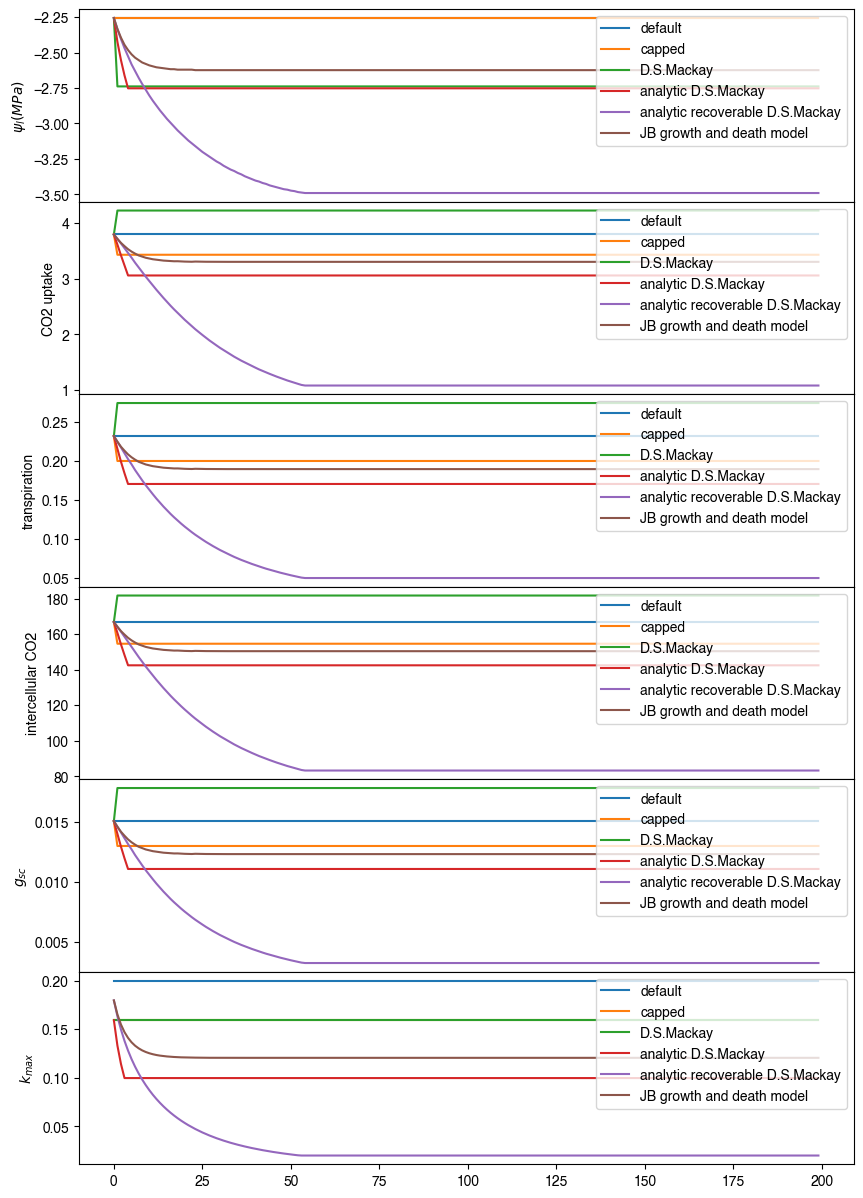

In [11]:
fig, axs = plt.subplots(6,1, sharex = True)
plot_y_labels = ["$\psi_l (MPa)$",
                 "CO2 uptake",
                 "transpiration",
                 "intercellular CO2",
                 "$g_{sc}$",
                 "$k_{max}$"]

plot_values = [optimal_leaf_water_potential,
               net_CO2_uptake,
               transpiration_rate,
               intercellular_CO2,
               stomatal_conductance_to_CO2,
               k_max]

# -- plot and format subfigures --
for i in range(len(plot_values)):
    for j in range(number_of_models):
        axs[i].plot(time, plot_values[i][j], label = profit_optimisation_model_labels[j])

    axs[i].set_ylabel(plot_y_labels[i])
    axs[i].legend(loc = "upper right")

# -- Format figure --
plt.subplots_adjust(wspace=0, hspace=0)
fig.set_figheight(15)
fig.set_figwidth(10)

plt.show()

# Dry down and recovery

Lets repeat the experiment above with a dry down of the soil, before reverting the soil water potential to its original value.

In [ ]:
# Reset the conductance models xylem damage.
for current_model in profit_optimisation_models:
    current_model.hydraulic_cost_model.hydraulic_conductance_model.reset_xylem_damage()

# -- setup soil water potential values --
time_steps = 300
soil_water_potentials = zeros(time_steps)

soil_water_potentials[0:100] = -0.5 # MPa
soil_water_potentials[100:200] = linspace(-0.5,-3.,100) # MPa
soil_water_potentials[200:] = -0.5 # MPa

# -- setup time --
time = [i*time_step_size for i in range(time_steps)]

# -- setup output arrays --
optimal_leaf_water_potential = zeros([number_of_models, time_steps])
net_CO2_uptake               = zeros([number_of_models, time_steps])
transpiration_rate           = zeros([number_of_models, time_steps])
intercellular_CO2            = zeros([number_of_models, time_steps])
stomatal_conductance_to_CO2  = zeros([number_of_models, time_steps])
PLC                          = zeros([number_of_models, time_steps])

for i in range(number_of_models):
    for j in range(time_steps):
        [optimal_leaf_water_potential[i,j],
         net_CO2_uptake[i,j],
         transpiration_rate[i,j],
         intercellular_CO2[i,j],
         stomatal_conductance_to_CO2[i,j]] = profit_optimisation_models[i].calculate_time_step(time_step_size,
                                                                                               soil_water_potentials[j],
                                                                                               air_temperature,
                                                                                               air_vapour_pressure_deficit,
                                                                                               air_pressure,
                                                                                               atmospheric_CO2_concentration,
                                                                                               intercellular_oxygen,
                                                                                               photosynthetically_active_radiation,
                                                                                               number_of_sample_points)

        PLC[i,j]   = profit_optimisation_models[i].hydraulic_cost_model.hydraulic_conductance_model.PLC(optimal_leaf_water_potential[i,j])

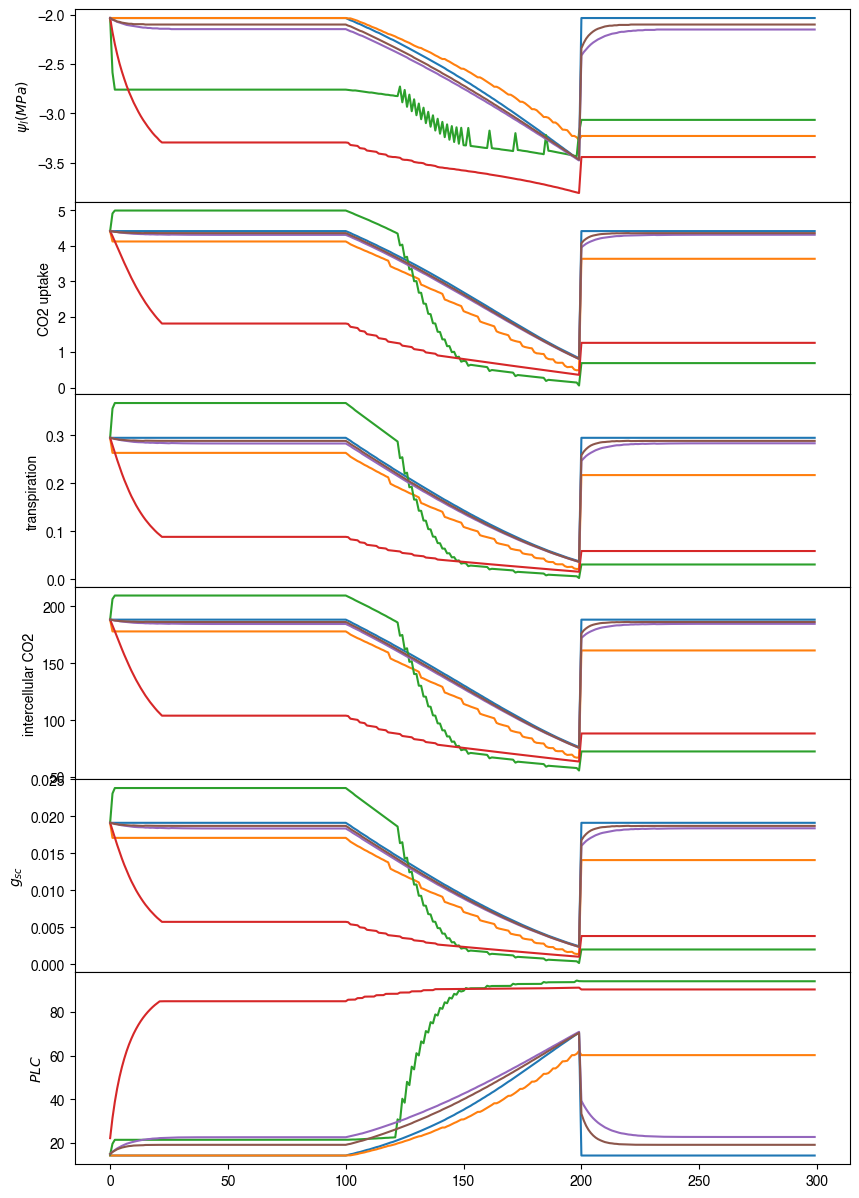

In [12]:
plot_y_labels = ["$\psi_l (MPa)$",
                 "CO2 uptake",
                 "transpiration",
                 "intercellular CO2",
                 "$g_{sc}$",
                 "$PLC$"]

plot_values = [optimal_leaf_water_potential,
               net_CO2_uptake,
               transpiration_rate,
               intercellular_CO2,
               stomatal_conductance_to_CO2,
               PLC]

# -- plot and format subfigures --
fig, axs = plt.subplots(len(plot_values),1, sharex = True)
for i in range(len(plot_values)):
    for j in range(number_of_models):
        axs[i].plot(time, plot_values[i][j], label = profit_optimisation_model_labels[j])

    axs[i].set_ylabel(plot_y_labels[i])
    #axs[i].legend(loc = "lower left")

# -- Format figure --
plt.subplots_adjust(wspace=0, hspace=0)
fig.set_figheight(15)
fig.set_figwidth(10)

plt.show()

# Consecutive drydowns

Now lets see what happens with two drydowns in a row.

In [13]:
# Reset the conductance models xylem damage.
for current_model in profit_optimisation_models:
    current_model.hydraulic_cost_model.hydraulic_conductance_model.reset_xylem_damage()

# -- setup soil water potential values --
time_steps = 400
soil_water_potentials = zeros(time_steps)

soil_water_potentials[  0:100] = -0.5 # MPa
soil_water_potentials[100:200] = linspace(-0.5,-3.,100) # MPa
soil_water_potentials[200:300] = linspace(-0.5,-3.,100) # MPa
soil_water_potentials[300:   ] = -0.5 # MPa
# -- setup time --
time = [i*time_step_size for i in range(time_steps)]

# -- setup output arrays --
optimal_leaf_water_potential = zeros([number_of_models, time_steps])
net_CO2_uptake               = zeros([number_of_models, time_steps])
transpiration_rate           = zeros([number_of_models, time_steps])
intercellular_CO2            = zeros([number_of_models, time_steps])
stomatal_conductance_to_CO2  = zeros([number_of_models, time_steps])
PLC                          = zeros([number_of_models, time_steps])

for i in range(number_of_models):
    for j in range(time_steps):
        [optimal_leaf_water_potential[i,j],
         net_CO2_uptake[i,j],
         transpiration_rate[i,j],
         intercellular_CO2[i,j],
         stomatal_conductance_to_CO2[i,j]] = profit_optimisation_models[i].calculate_time_step(time_step_size,
                                                                                               soil_water_potentials[j],
                                                                                               air_temperature,
                                                                                               air_vapour_pressure_deficit,
                                                                                               air_pressure,
                                                                                               atmospheric_CO2_concentration,
                                                                                               intercellular_oxygen,
                                                                                               photosynthetically_active_radiation,
                                                                                               number_of_sample_points)

        PLC[i,j]   = profit_optimisation_models[i].hydraulic_cost_model.hydraulic_conductance_model.PLC(optimal_leaf_water_potential[i,j])

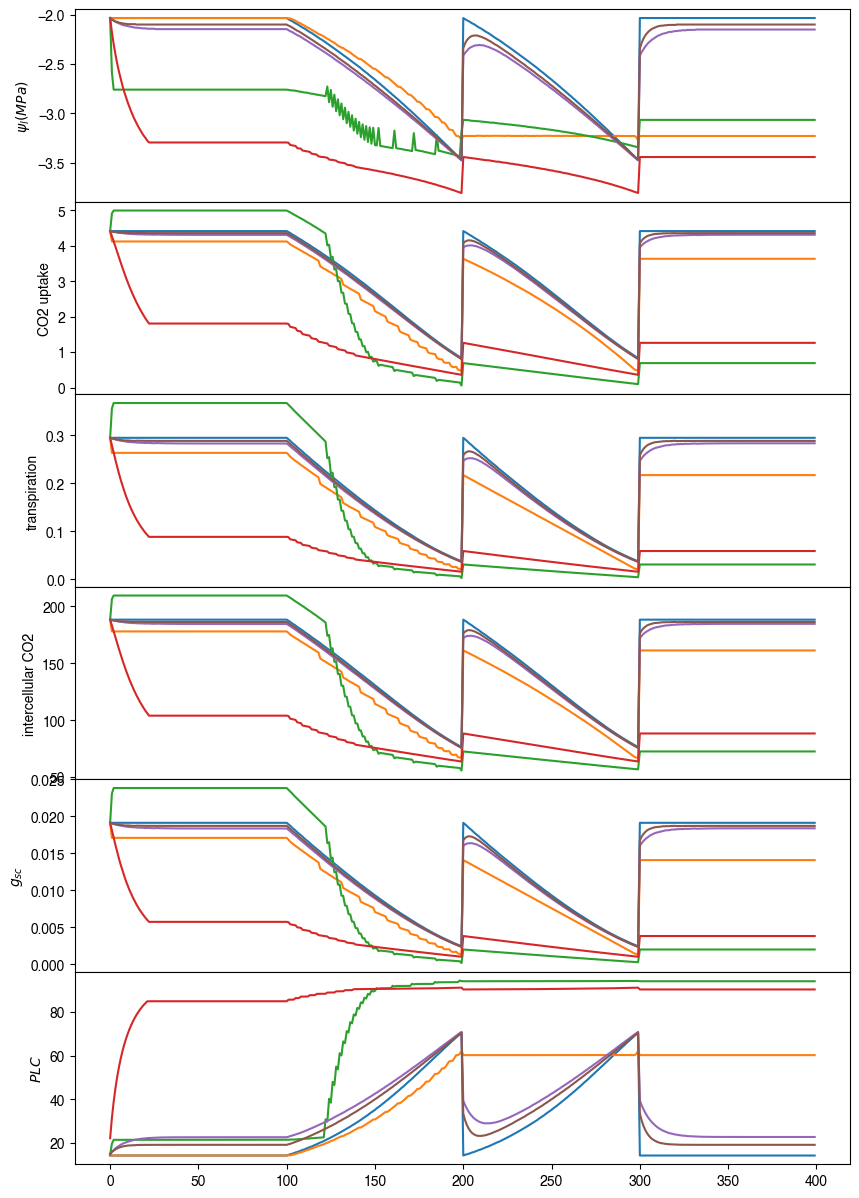

In [14]:
plot_y_labels = ["$\psi_l (MPa)$",
                 "CO2 uptake",
                 "transpiration",
                 "intercellular CO2",
                 "$g_{sc}$",
                 "$PLC$"]

plot_values = [optimal_leaf_water_potential,
               net_CO2_uptake,
               transpiration_rate,
               intercellular_CO2,
               stomatal_conductance_to_CO2,
               PLC]

# -- plot and format subfigures --
fig, axs = plt.subplots(len(plot_values),1, sharex = True)
for i in range(len(plot_values)):
    for j in range(number_of_models):
        axs[i].plot(time, plot_values[i][j], label = profit_optimisation_model_labels[j])

    axs[i].set_ylabel(plot_y_labels[i])
    #axs[i].legend(loc = "lower left")

# -- Format figure --
plt.subplots_adjust(wspace=0, hspace=0)
fig.set_figheight(15)
fig.set_figwidth(10)

plt.show()